<a href="https://colab.research.google.com/github/AsmaaSobhyy/Book_Clustering/blob/main/Final_Nlp_Book_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install --upgrade mlxtend
# !pip install pdfplumber
# !pip install kneed
#!pip install --upgrade gensim

In [4]:
import nltk
import requests 
from nltk.corpus import stopwords
import pandas as pd
import random
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.metrics import silhouette_score

In [5]:
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
import pdfplumber
import random

random.seed(0)

**a function that reads the book from gutenberg library and return it's text.**

In [7]:
def read_book(book_name):
    print(book_name)
    if 'txt' not in book_name:
        book_pdf = []
        with pdfplumber.open(book_name) as pdf:
            # x = pdf.pages
            for pdf_page in pdf.pages[14:59]:
                book_pdf.append(pdf_page.extract_text())
            text = '\n'.join(book_pdf)   
    else:
            book_name = book_name + '.txt'
            text = nltk.corpus.gutenberg.raw(book_name)
    return text

In [8]:
def read_from_url(url):
  response = requests.get(url)
  text=response.text.split('***')[2]
  return text

**tokinizing the text into a list of words, turning it to lower case and removing stop words.**<br>
*input : the text of the book<br>
output : a list of filtered words*

In [9]:
#tokinizing the words and removing all punctuation marks then changing it to lower case.
def filter_words(text):
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    tokenized_words = tokenizer.tokenize(text)
    tokenized_words = [token.lower() for token in tokenized_words]
    stop_words=set(stopwords.words("english"))
    stops = ['existentialism', 'albert','camus','stranger', 'cid','153']
    filtered_words=[]
    
    for w in tokenized_words:
        if w not in stop_words and w not in stops:
            filtered_words.append(w)
    return filtered_words

**Stemming and lemmatizing the text**<br>
*Stemming : coverting words like believing, believed, believes, and believe into believ*<br>
*Lemmatizing : coverting words into it's source, like better -> good*

In [10]:
def lem_words(filtered_words):
  wl=WordNetLemmatizer()
  lemmatized=[]
  for w in filtered_words:
    lm=wl.lemmatize(w)
    lemmatized.append(lm)
  return lemmatized

In [11]:
def stem_words(filtered_words):
  ps = PorterStemmer()
  wl=WordNetLemmatizer()
  stemmed=[]
  for w in filtered_words:
    st=ps.stem(w)
    stemmed.append(wl.lemmatize(st))
  return stemmed

**appending each N words into a partition and labeling them with the book name.**<br>
*input : filtered_words, book_name and number of words*<br>
*output : dataframe of the document as text, tokinized document and label.*

In [12]:
#append each 100 word to a document and label them with the book's name then returns a dataframe
#assumption: i removed the final document to maintain 100 word/document.
def create_docs(filtered_words,book_name,n_words=100):
    labeled_docs=[]
    tokinized_docs=[]
    for i in range(200):
        ###### Would be better if we could make this random choice the same each time #####
        start_token = random.choice(range(len(filtered_words)-100))
        end_token = start_token+100
        tokinized_docs.append(filtered_words[start_token:start_token+100])
        rand_words = filtered_words[start_token:start_token+100]
        rand_partition = ' '.join(rand_words)
        labeled_docs.append(rand_partition)

    labeled_docs= pd.DataFrame({'Document': labeled_docs,'tokinized_doc':tokinized_docs,'label':book_name})
    return labeled_docs

**taking random samples from the labeled documents.**

In [13]:
# take  a random variable
def take_sample(labeled_docs, sample_size):
    samples=labeled_docs.sample(sample_size,random_state=0)
    return samples

**collecting final steps to the function 'sample_book' that takes the book name and sample size and return the final sampled dataframe.**

In [14]:
def sample_book(book_name,sample_size,url,word_per_doc=100):
    if 'txt' not in url:
      path=url 
      text=read_book(path)
    else:
      text=read_from_url(url)
    filtered_words=filter_words(text)
    stemmed_words=stem_words(filtered_words)
    labeled_docs=create_docs(stemmed_words,book_name,word_per_doc)
    samples=take_sample(labeled_docs,sample_size)
    print(book_name)
    return samples

## Preparing model input
taking 200 sample from 5 books and appending them into 'samples',<br>
splitiing the data into features and labels, then splitting them into training set and testing set.

In [15]:
books_url=[('nihilism','https://www.gutenberg.org/cache/epub/4363/pg4363.txt'),
            ('nihilism','https://www.gutenberg.org/files/52881/52881-0.txt'),
           ('absurdity','/content/drive/MyDrive/CAMUS, Albert - The Stranger.pdf'),
           ('absurdity','/content/drive/MyDrive/plague.pdf'),
            ('exist','/content/drive/MyDrive/Nausea.pdf'),
            ('exist','/content/drive/MyDrive/Existentialism_artificial.pdf'),
           ]
books_count=len(books_url)
samples=pd.DataFrame()

for book in books_url:
  samples=samples.append(sample_book(book[0],200,book[1],150))

samples=samples.reset_index()
samples=samples.drop(columns=['index'])

nihilism
nihilism
/content/drive/MyDrive/CAMUS, Albert - The Stranger.pdf
absurdity
/content/drive/MyDrive/plague.pdf
absurdity
/content/drive/MyDrive/Nausea.pdf
exist
/content/drive/MyDrive/Existentialism_artificial.pdf
exist


In [16]:
samples

,Document,tokinized_doc,label
0,hoar groan genuin note self contempt belong ov...,"[hoar, groan, genuin, note, self, contempt, be...",nihilism
1,common good express contradict common alway sm...,"[common, good, express, contradict, common, al...",nihilism
2,lake longer move raptur sympathi worst danger ...,"[lake, longer, move, raptur, sympathi, worst, ...",nihilism
3,dong dangl sli nun ogl ave hour bell ring whol...,"[dong, dangl, sli, nun, ogl, ave, hour, bell, ...",nihilism
4,use anoth man expens short question alway inst...,"[use, anoth, man, expens, short, question, alw...",nihilism
...,...,...,...
1195,moral wider scope debat valid choos two could ...,"[moral, wider, scope, debat, valid, choos, two...",exist
1196,human found everi man mean man particular exam...,"[human, found, everi, man, mean, man, particul...",exist
1197,take upon respons attack send number men death...,"[take, upon, respons, attack, send, number, me...",exist
1198,impli freedom freedom will commun freedom free...,"[impli, freedom, freedom, will, commun, freedo...",exist


In [17]:
# Splitting the data into train and  test with ratio 80 : 20 
features= np.array(samples['Document'])
labels=np.array(samples['label'])
#X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True)
print(len(features))
# print(X_test.shape)

1200


In [18]:
def create_dataframe(matrix, tokens):
  doc_names = [f'doc_{i+1}' for i, _ in enumerate(matrix)]
  df = pd.DataFrame(data=matrix, index=doc_names, columns=tokens)
  return(df)

## Models

*a function that maps the names of the clusters into a number based on which cluster it belongs to.*

In [19]:
def map_cluster_to_class(df):
  #choosing the class of each cluster via majority voting
  label_0 = df[df['predicted']==0].value_counts().idxmax()
  label_1 = df[df['predicted']==1].value_counts().idxmax()
  label_2 = df[df['predicted']==2].value_counts().idxmax()

  ordered_labels = [label_0, label_1, label_2]

  #building the dict based on which we are going to do the cluster-class mapping
  mapping_dict = {}
  for ( label,number) in ordered_labels:
    mapping_dict[label] = number

  #mapping classes that were not considered
  # mapping_dict['nihilism_Thus Spake Zarathustra'] =  1
  print(mapping_dict)
  df['mapped_labels'] = df['actual'].replace(mapping_dict)
  return df

A function that calculates the avg silhouette score and the cappa score to evaluate various clustering methods.

In [20]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import cohen_kappa_score
def evaluate_clusters(train_df, actual_y, pred_y):
  silhouette_avg = silhouette_score(train_df, pred_y)
  kappa_score = cohen_kappa_score(pred_y, actual_y)
  return (silhouette_avg, kappa_score)

### BOW with K-means clustering

#### Text Transformation (BoW)

In [21]:
Bow_vect = CountVectorizer()
Bow_matrix = Bow_vect.fit_transform(features)
tokens_Bow = Bow_vect.get_feature_names()
X_Bow = Bow_matrix.toarray()

#### K-means clustering

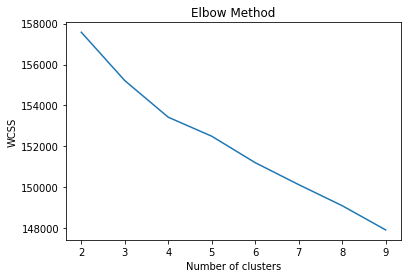

In [22]:
#Use elbow method to get optimal number of clusters
wcss = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_Bow)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [23]:
# a function that locates the optimal number of clusters
kl = KneeLocator(range(2, 10), wcss, curve="convex", direction="decreasing")
k_opt = kl.elbow
print(f'the optimal number of clusters is {k_opt}')


the optimal number of clusters is 4


In [24]:
kmeans = KMeans(n_clusters=k_opt, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_Bow)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

*After plotting WCSS for each model with different number of clusters the elbow wasn't very visible so we used a function to locate it, so the optimal number is 4 which means that it splitted a category into 2 clusters or an overlapping area.*

#### evaluating the model

In [25]:
pred_y = kmeans.fit_predict(X_Bow)
#comparing output
y_df_bow=pd.DataFrame({'actual':list(samples['label']),'predicted':pred_y})
y_df_bow.head(2)

,actual,predicted
0,nihilism,1
1,nihilism,1


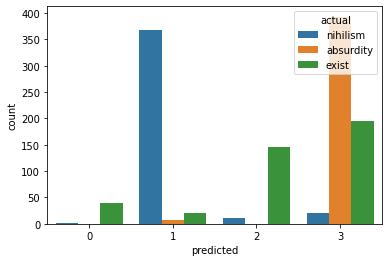

In [26]:
#plotting values in each class from each topic
sns.countplot(x="predicted", hue="actual", data=y_df_bow)

*when splitting the data into 4 clusters we can see that the class existentialism is distrebuted into the 4 clusters, the model can obviously seperate the nihilism. class zero is almost empty or can be merged with class 2 so we'll use number of clusters = 3 in the upcoming cells.*

In [27]:
#mapping the clusters
y_df_bowcopy = y_df_bow.copy()
y_df_bowcopy
# mapping cluster names into numbers
y_df_bowcopy.replace({'actual': {'nihilism':0, 'exist':1, 'absurdity':2}}, inplace = True)
# mapping predicted into cluster numbers
y_df_bowcopy.replace({'predicted': {3:2,2:1, 1:0, 0:1}}, inplace = True)


In [28]:
##evaluation function
#y_df_bow = map_cluster_to_class(y_df_bow)
silhouette_avg, kappa_score=evaluate_clusters(X_Bow, y_df_bowcopy['actual'], y_df_bow['predicted'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.02171979121255997 
kappa score = -0.1748670212765957


### TF-IDF with K-means clustering

In [29]:
x_train = samples['Document']

pipe= Pipeline([
               ('tfidf', TfidfVectorizer()),
               ('clf', KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)),
              ])
pipe.fit(x_train)

y_pred_tf = pipe.predict(x_train)

In [30]:
vec = pipe['tfidf']
x_train_vec = vec.fit_transform(x_train)

In [31]:
y_df_tfidf=pd.DataFrame({'actual':list(samples['label']),'predicted':y_pred_tf})
y_df_tfidf.head(2)

,actual,predicted
0,nihilism,0
1,nihilism,0


#### evaluation

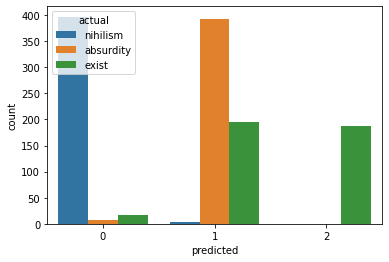

In [32]:
#plotting values in each class from each topic
sns.countplot(x="predicted", hue="actual", data=y_df_tfidf)

*We can see here that the output is better than the first case but the model is still a bit confused about class absurdity.*

In [33]:
#mapping the clusters
y_df_tfidfcopy = y_df_tfidf.copy()
y_df_tfidfcopy
# mapping cluster names into numbers
y_df_tfidfcopy.replace({'actual': {'nihilism':0, 'exist':1, 'absurdity':2}}, inplace = True)
# mapping predicted into cluster numbers
y_df_tfidfcopy.replace({'predicted': {2:1, 1:2, 0:0}}, inplace = True)

In [34]:
## evaluating 
# y_df_tfidf = map_cluster_to_class(y_df_tfidf)
silhouette_avg, kappa_score=evaluate_clusters(x_train_vec, y_df_tfidfcopy['actual'], y_df_tfidfcopy['predicted'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.013384565962908405 
kappa score = 0.72125


*the avg silhouette scores for  tfidf vectorization method is smaller while the kappa score is significantly higher. it's a tradeoff but since the kappa score difference is higher we'll consider tfidf model better.*

### Word-Embedding with K-means

In [35]:
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

#training the word2vec model with our dataset
model = Word2Vec(samples['tokinized_doc'], vector_size=50, window=5, min_count=1, workers=4)
model.save("word2vec.model")

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [36]:
#converting each record with word2vec then stacking the words into 1 array
#preparing the input for the model
vec_doc=[]
for doc in samples['tokinized_doc']:
  vec_doc.append([model.wv[x] for x in doc])
samples['w2v_doc']=vec_doc
samples['flat_w2v']=[ np.hstack(x) for x in vec_doc ]
samples.head(1)

,Document,tokinized_doc,label,w2v_doc,flat_w2v
0,hoar groan genuin note self contempt belong ov...,"[hoar, groan, genuin, note, self, contempt, be...",nihilism,"[[-0.0575338, -0.04364316, -0.009044527, 0.032...","[-0.0575338, -0.04364316, -0.009044527, 0.0322..."


In [37]:
#melting each flat_w2v record into a list of features to train the model
train_df=pd.DataFrame(list(samples['flat_w2v']),columns=[str(x) for x in range(len(samples['flat_w2v'][0]))])
train_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,4960,4961,4962,4963,4964,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982,4983,4984,4985,4986,4987,4988,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,-0.057534,-0.043643,-0.009045,0.032274,0.031935,-0.05194,0.052882,0.063617,-0.112218,0.001175,0.006676,-0.080535,-0.05232,0.079505,0.002045,0.038606,0.017822,0.037458,-0.078829,-0.033879,-0.042052,0.07403,0.156784,0.014079,0.085009,-0.028402,-0.006539,-0.004996,-0.115829,0.02099,-0.019333,0.031269,-0.028159,0.079513,-0.052096,0.04952,0.016063,-0.009628,0.016637,-0.040909,...,0.043784,-0.111716,-0.050844,0.060692,0.004925,0.064898,0.04521,0.015128,-0.102211,-0.055159,-0.044436,0.074804,0.179599,-0.00036,0.137221,-0.004386,-0.016677,-0.020226,-0.160871,0.014046,-0.016453,0.000395,-0.033751,0.11843,-0.054799,0.095936,0.00333,-0.024501,0.021233,-0.065681,0.095653,-0.049935,-0.00365,0.040917,0.113511,0.022036,0.035792,-0.066959,0.016341,0.07182


*training kmeans model with 3 custers*

In [38]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(train_df)

#### evaluation

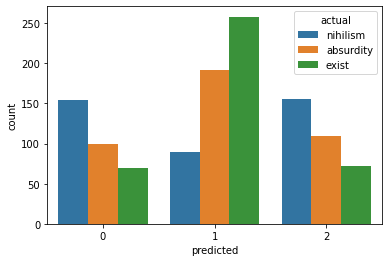

In [39]:
##evaluation
y_df_w2v=pd.DataFrame({'actual':list(samples['label']),'predicted':pred_y})
#plotting values in each class from each topic
sns.countplot(x="predicted", hue="actual", data=y_df_w2v)

*The output of this model is significantly worse than the first 2 cases and the 3 classes are completely overlapping.*<br>
*for evaluation we'll consider class 0 to be nihilism, 1 to be absurdity and 2 to be existentialism.*

In [40]:
#mapping the clusters
y_df_w2vcopy = y_df_w2v.copy()
y_df_w2vcopy
# mapping cluster names into numbers
y_df_w2vcopy.replace({'actual': {'nihilism':0, 'exist':1, 'absurdity':2}}, inplace = True)
# mapping predicted into cluster numbers
y_df_w2vcopy.replace({'predicted': {2:1, 1:2, 0:0}}, inplace = True)

In [41]:
silhouette_avg, kappa_score= evaluate_clusters(train_df, y_df_w2vcopy['actual'], y_df_w2vcopy['predicted'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.018947981263435675 
kappa score = 0.02124999999999999


*as predicted both cappa score and silhouette score are worse.*<br>
*since the output of the tfidf vectorization had the best results we'll try the rest of the models with tfidf.*

###TF-IDF with Expectation Maximization

we'll train the EM model with 'x_train_vec' representing the tfidf vectorization output that we implemented in some previous cells.

In [42]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
sns.set()

In [43]:
#training the EM
from sklearn.decomposition import PCA
from matplotlib import pyplot


n = 3
gmm = GaussianMixture(n_components=n)
gmm.fit(x_train_vec.toarray())
pred_y = gmm.predict(x_train_vec.toarray())

# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(x_train_vec)

# pyplot.scatter(reduced_features[:, 0], reduced_features[:, 1], c=predicted_labels, cmap='viridis');

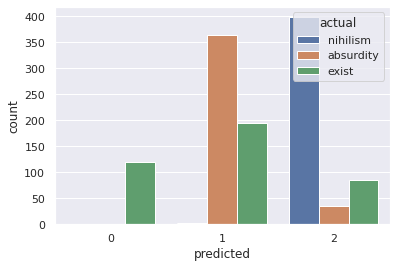

In [44]:
##evaluation
y_df_EM=pd.DataFrame({'actual':list(samples['label']),'predicted':pred_y})
#plotting values in each class from each topic
sns.countplot(x="predicted", hue="actual", data=y_df_EM)

*We can see that the output of this model is slightly worse than the tfidf with kmeans but better than the word2vec one.*

In [45]:
#mapping the clusters
y_df_EMcopy = y_df_EM.copy()
y_df_EMcopy
# mapping cluster names into numbers
y_df_EMcopy.replace({'actual': {'nihilism':0, 'exist':1, 'absurdity':2}}, inplace = True)
# mapping predicted into cluster numbers
y_df_EMcopy.replace({'predicted': {2:0, 1:2, 0:1}}, inplace = True)

In [46]:
silhouette_avg, kappa_score= evaluate_clusters(x_train_vec.toarray(), y_df_EMcopy['actual'], y_df_EMcopy['predicted'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.011770895297287686 
kappa score = 0.6025


*as excpected it's better than the w2v model but still tfidf with kmeans is our champion so far.*

### Tf-idf with Agglomerative clustering

In [47]:
#tfidf vectorizaton
Tfidf_vect = TfidfVectorizer()
tfidf_matrix = Tfidf_vect.fit_transform(features)
tokens_tfidf = Tfidf_vect.get_feature_names()
X_tfidf = tfidf_matrix.toarray()

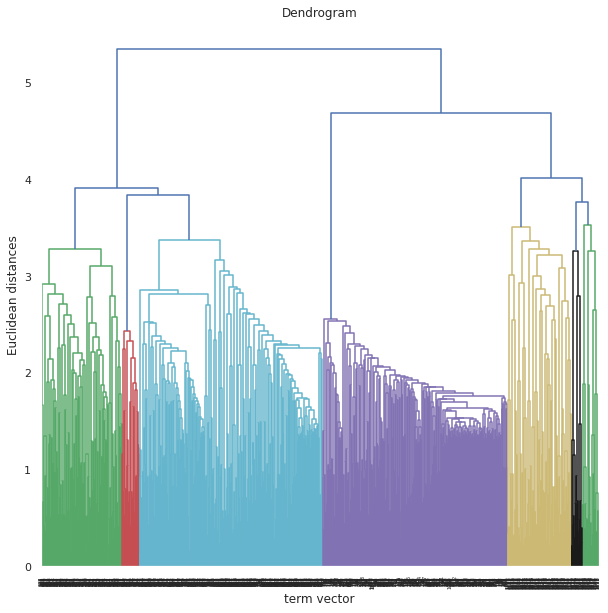

In [48]:
plt.figure(figsize=(10,10))
dendrogram = sch.dendrogram(sch.linkage(X_tfidf, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('term vector')
plt.ylabel('Euclidean distances')
plt.show()

To determine the number of clusters in agglomerative clustering we use dendrogram. Dendrogram is a diagram that shows the hierarchical relationship between the terms' vectors. The vertical lines in the dendrogram represent the euclidean distance between the vectors. If the height of the vertical line joining two objects is small, that means these two objects are similar. The number of clusters is determined by drawing a horizontal line through the dendrogram at the desired distance. Each group of observations joined together below the horizontal forms a cluster. Dendrograms don't determine the optimal number of clusters. However, they can be helpful to visualize the similarity between the objects and it will be up to the data scientist to decide where to draw the horizontal line.

In [49]:
agglo = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
y_pred = agglo.fit_predict(X_tfidf)

In [50]:
X = create_dataframe(X_tfidf,tokens_tfidf)
X['Cluster'] = agglo.labels_ 
word_frequencies_by_cluster = X.groupby('Cluster').sum()

#### evaluation

In [58]:
print("Top terms per cluster:")
for i in range(agglo.n_clusters):
  print("Cluster %d:" % i),
  cluster_top = word_frequencies_by_cluster.loc[i].sort_values(ascending=False)
  txt=''
  for ind in range(10):
    txt = txt+', '+ cluster_top[cluster_top == cluster_top[ind]].index[0]
  print(txt)

Top terms per cluster:
Cluster 0:
, man, choos, upon, exist, one, action, human, say, mean, valu
Cluster 1:
, said, one, time, like, day, ask, look, rieux, go, littl
Cluster 2:
, one, _â, perhap, man, philosoph, also, moral, even, good, power


*these are the most used words in each cluster, we can see that cluster 0 which is existentialism has words like man, human and action which is very logical while cluster 2 which is nihilism have words like god, moral and philosoph.*

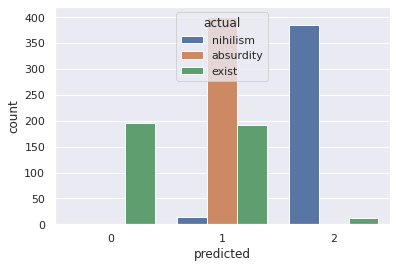

In [51]:
## evaluation
y_df_H=pd.DataFrame({'actual':list(samples['label']),'predicted':y_pred})
#plotting values in each class from each topic
sns.countplot(x="predicted", hue="actual", data=y_df_H)

*the output of this model visually is better, very simmilar to the tfidf with kmeans.*

In [52]:
#mapping the clusters
y_df_Hcopy = y_df_H.copy()
y_df_Hcopy
# mapping cluster names into numbers
y_df_Hcopy.replace({'actual': {'nihilism':0, 'exist':1, 'absurdity':2}}, inplace = True)
# mapping predicted into cluster numbers
y_df_Hcopy.replace({'predicted': {2:0, 1:2, 0:1}}, inplace = True)

In [53]:
silhouette_avg, kappa_score= evaluate_clusters(X_tfidf, y_df_Hcopy['actual'], y_df_Hcopy['predicted'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.013485025970755142 
kappa score = 0.7262500000000001


*The cappa score for this model is very good and the numbers are very simmilar to tfidf with kmeans model, this is our second model.*

### BOW with LDA

In [55]:
from gensim.models import LdaMulticore
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models


# Create a corpus from a list of texts
dictionary = Dictionary(samples['tokinized_doc'])
#Filter out tokens that appear in less than 15 doc, or more than 50% in all docs and take top 10000 word
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=10000)
#doc to bow
bow_corpus = [dictionary.doc2bow(doc) for doc in samples['tokinized_doc']]

**calculationg the coherence for multiple number of topics and plotting to decide what is the optimal number.**

In [56]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    coherence_values_umass= []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,texts=texts, dictionary=dictionary, coherence='c_v')
        coherencemodel_umass= CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        coherence_values_umass.append(coherencemodel_umass.get_coherence())
    return model_list, coherence_values, coherence_values_umass

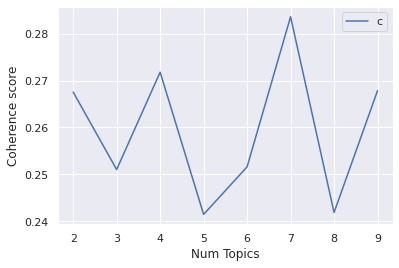

In [59]:
model_list, coherence_values,coherencemodel_umass = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=samples['tokinized_doc'], start=2, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

*number of topics 7 have highest coherence but may have repeated keywords in the topic so we'll pick 4 as it has high coherence and better clusters size.*

In [120]:
# Train the model on the bow corpus.
n_topics=4
lda_model = LdaMulticore(bow_corpus, num_topics=n_topics, id2word=dictionary, passes=2, workers=2,random_state=0)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"time" + 0.007*"even" + 0.006*"would" + 0.006*"say" + 0.006*"u" + 0.005*"alway" + 0.005*"man" + 0.005*"plagu" + 0.005*"like" + 0.005*"go"
Topic: 1 
Words: 0.013*"man" + 0.008*"said" + 0.008*"like" + 0.008*"say" + 0.007*"make" + 0.007*"time" + 0.006*"look" + 0.006*"day" + 0.006*"would" + 0.006*"could"
Topic: 2 
Words: 0.016*"man" + 0.008*"would" + 0.008*"said" + 0.006*"say" + 0.006*"like" + 0.006*"time" + 0.006*"human" + 0.006*"mean" + 0.005*"ask" + 0.005*"could"
Topic: 3 
Words: 0.012*"man" + 0.010*"â" + 0.008*"even" + 0.007*"u" + 0.007*"would" + 0.007*"like" + 0.006*"moral" + 0.006*"also" + 0.006*"say" + 0.006*"may"


In [121]:
topic=[]
acc=[]
for doc in bow_corpus:
  t=sorted(lda_model[doc], key=lambda tup: -1*tup[1])[0]
  topic.append(t[0])
  acc.append(t[1])

In [126]:
Lda_df=pd.DataFrame({'actual':list(samples['label']),'predicted':topic})
Lda_df.head(2)

,actual,predicted
0,nihilism,3
1,nihilism,3


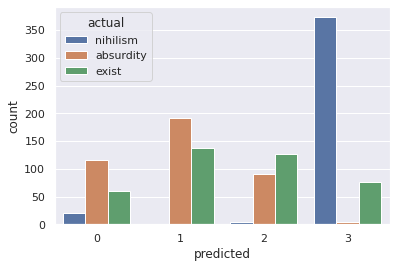

In [127]:

#plotting values in each class from each topic
sns.countplot(x="predicted", hue="actual", data=Lda_df)

In [128]:
#mapping the clusters
Lda_df_copy = Lda_df.copy()
Lda_df_copy
# mapping cluster names into numbers
Lda_df_copy.replace({'actual': {'nihilism':0, 'exist':1, 'absurdity':2}}, inplace = True)
# mapping predicted into cluster numbers
Lda_df_copy.replace({'predicted': {3:0,2:1, 1:2, 0:2}}, inplace = True)

In [129]:
silhouette_avg, kappa_score= evaluate_clusters(X_Bow, Lda_df_copy['actual'], Lda_df_copy['predicted'])
print(f'avg silhouette score = {silhouette_avg} \nkappa score = { kappa_score}')

avg silhouette score = 0.006513797140747426 
kappa score = 0.50625


*Both cappa and silhouette are ok for this model. the model is still confused between a book in existentialism, it classifies it as absurdity.*

#### evaluation

In [74]:
# !pip install  pyLDAvis

In [73]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook(local=True)
pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.063634  0.006099       1        1  35.833464
1      0.038280  0.004560       2        1  28.208939
2      0.019441  0.020444       3        1  19.057422
0      0.005912 -0.031103       4        1  16.900175, topic_info=       Term         Freq        Total Category  logprob  loglift
253    time   558.000000   558.000000  Default  30.0000  30.0000
1233  plagu   138.000000   138.000000  Default  29.0000  29.0000
1145      â   400.000000   400.000000  Default  28.0000  28.0000
26      man  1056.000000  1056.000000  Default  27.0000  27.0000
213    said   505.000000   505.000000  Default  26.0000  26.0000
...     ...          ...          ...      ...      ...      ...
269    know    64.604127   379.515970   Topic4  -5.4638   0.0072
77     like    76.962065   588.895531   Topic4  -5.2887  -0.2571
568     day    63.362033   380.107323   Topic4  -5.4832  -0.0137
26      man    81.796080  1056.005861   Topic4  -5.2278  -0.7802
80     make    64.031554   464.761461   Topic4  -5.4727  -0.2043

[316 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1153      1  0.242730    _
1153      2  0.101137    _
1153      3  0.141592    _
1153      4  0.505687    _
1147      1  0.775969   _â
...     ...       ...  ...
194       4  0.259420   ye
1145      1  0.776110    â
1145      2  0.064884    â
1145      3  0.082352    â
1145      4  0.074866    â

[947 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

Values of lambda that are very close to zero will show terms that are more specific for a chosen topic. Meaning that you will see terms that are "important" for that specific topic but not necessarily "important" for the whole corpus.<br>

Values of lambda that are very close to one will show those terms that have the highest ratio between frequency of the terms for that specific topic and the overall frequency of the terms from the corpus.

In [130]:
#a mmis classified record 
Lda_df_copy[Lda_df_copy['actual'] != Lda_df_copy['predicted']]


,actual,predicted
15,0,2
59,0,2
61,0,2
66,0,1
69,0,1
...,...,...
1192,1,2
1193,1,0
1195,1,2
1197,1,0


(0, 0.98671395)
exist : orange , absurd : green , nihilism : blue
predicted as : exist , actual is nihilism


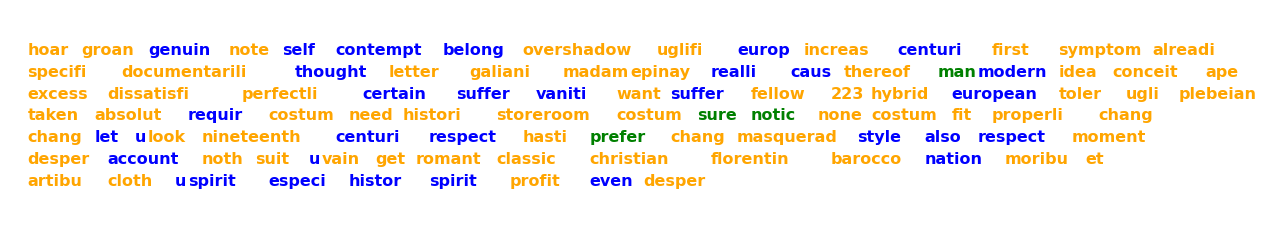

In [133]:
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
fig, ax = plt.subplots(1, 1)
print(sorted(lda_model[bow_corpus[15]], key=lambda tup: -1*tup[1])[0])
mycolors = ['orange','orange','green','blue']
print(f"exist : {mycolors[0]} , absurd : {mycolors[2]} , nihilism : {mycolors[3]}")
print(f"predicted as : exist , actual is {samples['label'][15]}")
word_pos = 0.06
y_pos=0.8
n=0
for word in samples['tokinized_doc'][0][:100]:
  n=n+1
  word_topic=sorted(lda_model[dictionary.doc2bow([word])], key=lambda tup: -1*tup[1])[0][0]

  ax.text(word_pos, y_pos, word,
          horizontalalignment='left',
          verticalalignment='center',
          fontsize=16, color=mycolors[word_topic],
          transform=ax.transAxes, fontweight=700)
  word_pos += .04 * len(word)  # to move the word for the next iter
  if n == 15:
    n=0
    y_pos-= 0.1
    word_pos = 0.06
  ax.axis('off')
  

we have here a misclassified record, the words in orange are why the model chose existentialism while blue is the words that belong to the nihilism cluster which is the actual label.

## Error Analysis

**we'll invistigate more in the output of the TF-IDF with kmeans Model**<br>
In this  [paper](https://arxiv.org/pdf/2003.01670.pdf) you can see how they used 'svm' as a means for mapping the features and their clusters in order to explain them, since XAI for clustering is still a wide research area that requires more efforts and investigation.


In [76]:
# !pip install lime
# !pip install eli5

In [77]:
import eli5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [78]:
x_train = samples['Document']
y_train = y_pred_tf
true_labels = [ 'nihilism', 'absurdity','exist'] # check this from the mapping of confusion matrix too/snsplot

In [80]:
from sklearn.linear_model import LogisticRegressionCV

pipe_LR= Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', LogisticRegressionCV(max_iter = 300, random_state=0)),
                   ])

pipe_LR.fit(x_train, y_train)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated.

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
    

In [81]:
clf=pipe_LR['clf']
vec=pipe_LR['tfidf']

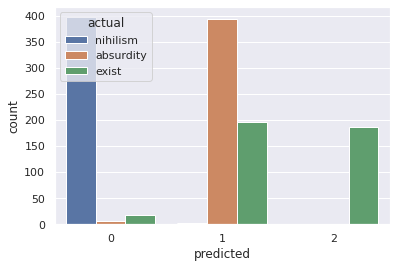

In [90]:
sns.countplot(x="predicted", hue="actual", data=y_df_tfidf)

In [91]:
y_df_copy = y_df_tfidf.copy()
y_df_copy
# df.replace({'A': {0: 100, 4: 400}})
y_df_copy.replace({'predicted': {1:'absurdity', 2:'exist', 0:'nihilism'}}, inplace = True)
# y_df_copy.replace({'y_actual': {'nihilism':2, 'adventure':0, 'History':1}}, inplace = True)
misclass_df = y_df_copy.loc[y_df_copy['predicted'] != y_df_copy['actual']]
len(misclass_df)
misclass_df.head()  ## Out of 1000 records --> 244 were misclassified

,actual,predicted
266,nihilism,absurdity
279,nihilism,absurdity
359,nihilism,absurdity
655,absurdity,nihilism
664,absurdity,nihilism


In [92]:
eli5.show_prediction(clf, x_train.iloc[240], vec=vec, target_names=true_labels)

/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:40: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:46: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:40: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:46: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:40: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/e

In [93]:
eli5.show_prediction(clf, x_train.iloc[266], vec=vec, target_names=true_labels)

/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:40: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:46: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:40: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:46: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/eli5/templates/target_header.html:40: DeprecationWarning: 'soft_unicode' has been renamed to 'soft_str'. The old name will be removed in MarkupSafe 2.1.
/usr/local/lib/python3.7/dist-packages/e

In [94]:
# lime needs vectorizer that has fit and fit_transform
# eli5 wants linear svm and this may not classify our problem correctly; try logistic
from lime import lime_text
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=true_labels)

In [95]:
exp = explainer.explain_instance(x_train.iloc[240], pipe_LR.predict_proba, num_features=6, top_labels=3)

exp.show_in_notebook()

## Final Innsights
![Image](Trial_Notebooks/Insight.png "Insights")

We can see it clearly that for cluster 0: [Nihilism], words as “soul”, “spirit” occur frequently as nihilism focuses on abolishing any meaning for this life which primarily emanates from inside— spiritual aspect. \\
While for cluster 1 [Existentialism], the top words are the ones as “man”,”action”,”freedom”,”upon” which aligns with the core of existentialism that focuses on human being, the centralization of the man and his ultimate ‘freedom’. \\
Lastly for [Absurdity] or cluster 2, it has no one defined cluster, rather it overlaps with others since it uses more of a natural voice with commonly used words.
